In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### Learning curves

In [2]:
from sklearn.datasets import load_digits

In [3]:
digits = load_digits()

In [4]:
X, y = digits.data, digits.target

In [5]:
X.shape
# 8x8 BW image

(1797, 64)

In [10]:
X[0]

array([  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
        15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
         8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
         5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
         1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
         0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.])

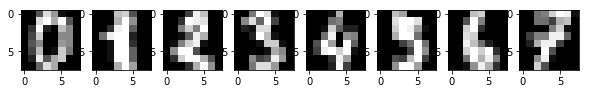

In [16]:
plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(X.reshape(-1, 8, 8)[i], cmap='gray')

In [17]:
from sklearn.model_selection import learning_curve

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import EarlyStopping

In [21]:
K.clear_session()

In [22]:
model = Sequential()
model.add(Dense(16, input_shape=(64,), activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [23]:
# store the initial random weights
initial_weights = model.get_weights()

In [29]:
y_cat = to_categorical(y, 10)

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3)

In [34]:
train_sizes = (len(X_train) * np.linspace(0.1, 0.999, 4)).astype(int)
train_sizes

array([ 125,  502,  879, 1255])

In [37]:
train_scores = []
test_scores = []

for train_size in train_sizes:
    X_train_frac, _, y_train_frac, _ = train_test_split(X_train, y_train, train_size=train_size)
    
    # at each iteration, reset the weights of the model.
    # to the initial random weights
    model.set_weights(initial_weights)
    
    h = model.fit(X_train_frac, y_train_frac, verbose=0, epochs=300, 
                  callbacks=[EarlyStopping(monitor='loss', patience=1)])
    
    r = model.evaluate(X_train_frac, y_train_frac, verbose=0)
    train_scores.append(r[-1])
    
    e = model.evaluate(X_test, y_test, verbose=0)
    test_scores.append(e[-1])
    
    print("Done size: ", train_size)

Done size:  125
Done size:  502
Done size:  879
Done size:  1255


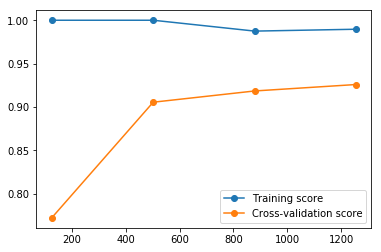

In [38]:
plt.plot(train_sizes, train_scores, 'o-', label='Training score')
plt.plot(train_sizes, test_scores, 'o-', label='Cross-validation score')
plt.legend(loc='best')

### Batch Normalization

In [45]:
X_train.shape[1:]

(64,)

In [39]:
from keras.layers import BatchNormalization

In [50]:
def repeated_training(X_train,
                     y_train,
                     X_test,
                     y_test,
                     units=512,
                     activation='sigmoid',
                     optimizer='sgd',
                     do_bn=False,
                     epochs=10,
                     repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()
        
        model = Sequential()
        
        # First fully connected layer
        model.add(Dense(units,
                       input_shape=X_train.shape[1:],
                       kernel_initializer='normal',
                       activation=activation))
        if do_bn:
            model.add(BatchNormalization())
            
        # secondly fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())
            
        # thirdly fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())   
        
        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer, 'categorical_crossentropy', metrics=['accuracy'])
        
        h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0)
        
        histories.append([h.history['acc'], h.history['val_acc']])
        print(repeat, end=' ')
    
    histories = np.array(histories)

    
    #calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [51]:
mean_acc, std_acc, mean_acc_val, std_acc_val = repeated_training(X_train, y_train, X_test, y_test, do_bn=False)

0 1 2 


In [52]:
mean_acc_bn, std_acc_bn, mean_acc_val_bn, std_acc_val_bn = repeated_training(X_train, y_train, X_test, y_test, do_bn=True)

0 1 2 


In [53]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

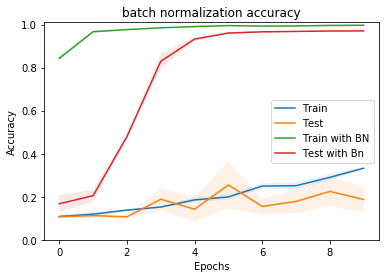

In [54]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_bn, std_acc_bn)
plot_mean_std(mean_acc_val_bn, std_acc_val_bn)
plt.ylim(0, 1.01)
plt.title("batch normalization accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with BN', 'Test with Bn'])